# TF-ILF/TF-IDFを用いたログ解析

# Import

In [1]:
# import
import os
import sys
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
sys.path.append(os.path.join(os.path.dirname("__file__"), "./src/"))
import load_log
from data_preprocessing import FeatureExtraction
from sklearn.ensemble import RandomForestClassifier
from model import PUAdapter, PUAdapterWrapper
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Config

In [2]:
class Config:
    #log_path = "./data/bgl/rawlog.log"
    log_path = "./data/bgl/BGL_2k.log"
    output_path = "./data/bgl/rawlog_after.log"
    train_size = 0.8
    output_dir = "./model/" #  + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + "/"
    #os.mkdir(output_dir)
    mode = "train"
    model_dir = "./model/model/"
config = Config

# データ取得&データ前処理
* **`df`**
   * `log` : 生ログデータ
   * `log(after)` : 正規表現によるデータ加工後のログデータ
   * `label`: 0(正常) or 1(異常)

In [3]:
df = load_log.load_bgl(config)
display(df)

,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
1,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
2,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
3,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
4,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.4...,NE NE RAS KERNEL INFO double hummer alignment ...,0,normal
...,...,...,...,...
1995,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-22.3...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1996,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-23.4...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1997,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-23.4...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1998,2005.12.27 R37-M1-NC-C:J02-U11 2005-12-27-01.2...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal


# EDA

In [4]:
print("ログデータ(正常)")
display(df[df["label"]==0].head())
print("ログデータ(異常)")
display(df[df["label"]==1].head())
print("異常/正常別 件数")
display(pd.DataFrame(df["label"].value_counts(), columns=["label"]))
print("異常種類別 件数")
display(pd.DataFrame(df["category"].value_counts()))

ログデータ(正常)


,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
1,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
2,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
3,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
4,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.4...,NE NE RAS KERNEL INFO double hummer alignment ...,0,normal


ログデータ(異常)


,log,log(after),label,category
8,2005.06.04 R04-M1-N4-I:J18-U11 2005-06-04-00.2...,RAS APP FATAL ciod failed to read message pref...,1,APPREAD
9,2005.06.04 R27-M1-N4-I:J18-U01 2005-06-04-00.2...,RAS APP FATAL ciod failed to read message pref...,1,APPREAD
103,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.3...,RAS KERNEL FATAL data TLB error interrupt,1,KERNDTLB
104,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.4...,RAS KERNEL FATAL data TLB error interrupt,1,KERNDTLB
105,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.4...,RAS KERNEL FATAL data TLB error interrupt,1,KERNDTLB


異常/正常別 件数


,label
0,1857
1,143


異常種類別 件数


,category
normal,1857
KERNDTLB,60
KERNSTOR,30
APPSEV,17
KERNMNTF,11
KERNTERM,7
KERNREC,5
APPRES,4
APPREAD,3
KERNRTSP,2


# データ分割  


* **`学習用データ`**  
    * `log`: 生ログデータ
    * `label`: 0(未知の正常) or 1(未知の異常) or -1(既知として扱う異常)
    * `category` : 異常の種類(正常の場合はnormal)
  
* **`推論用データ`**  
    * 正常データ(unlabel) ： 
    * 異常データ(unlabel) ：
    * 正常データ(label) ：
    * 異常データ(label) ：

In [5]:
#train, test = train_test_split(df, train_size=config.train_size, random_state=1, shuffle=True, stratify=df["label"])
train, test = train_test_split(df, train_size=config.train_size, random_state=1, shuffle=True)


train_labeled, train_unlabeled =train_test_split(train[train["label"]==1], train_size=0.2, random_state=1, shuffle=True) 
train_labeled["label"] = -1
train = pd.concat([train[train["label"]==0], train_unlabeled, train_labeled])

train_info = train.groupby(["label", "category"]).size()
train_info = pd.DataFrame(train_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
print(" ----- + 学習データの異常別件数 + -----")
display(train_info)
test_info = test.groupby(["label", "category"]).size()
test_info = pd.DataFrame(test_info).rename(columns={0:"count"})
print(" ----- + 推論データの異常別件数 + -----")
display(test_info)

 ----- + 学習データの異常別件数 + -----


count
label category       
 1    KERNDTLB     43
      KERNSTOR     18
      APPSEV       10
      KERNMNTF      6
      KERNTERM      5
      APPREAD       2
      APPTO         2
      KERNREC       2
      APPOUT        1
      APPRES        1
 0    normal     1488
-1    KERNDTLB      5
      KERNSTOR      5
      APPSEV        3
      APPRES        2
      KERNREC       2
      KERNRTSP      2
      APPCHILD      1
      KERNMNTF      1
      KERNTERM      1

 ----- + 推論データの異常別件数 + -----


count
label category       
0     normal      369
1     APPREAD       1
      APPRES        1
      APPSEV        4
      KERNDTLB     12
      KERNMNTF      4
      KERNREC       1
      KERNSTOR      7
      KERNTERM      1

# 特徴量抽出

In [6]:
display(train)
display(test)

,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
816,2005.07.10 R24-M1-N6-C:J05-U01 2005-07-10-07.4...,RAS KERNEL INFO generating core,0,normal
790,2005.07.09 R35-M0-NE-C:J03-U11 2005-07-09-21.2...,NE NE RAS KERNEL INFO generating core,0,normal
361,2005.06.20 R14-M1-N0-I:J18-U01 2005-06-20-16.2...,RAS APP FATAL ciod Error loading home draeger ...,0,normal
592,2005.07.04 R34-M0-N5-C:J04-U01 2005-07-04-07.3...,RAS KERNEL INFO generating core,0,normal
...,...,...,...,...
1382,2005.09.02 R04-M0-NC-I:J18-U11 2005-09-02-13.5...,NC NC RAS KERNEL FATAL Lustre mount FAILED poi...,-1,KERNMNTF
128,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-19.3...,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB
823,2005.07.11 R04-M0-N1-C:J02-U01 2005-07-11-14.0...,RAS KERNEL FATAL rts stopping execution,-1,KERNRTSP
209,2005.06.14 R20-M0-NE-C:J02-U01 2005-06-14-09.5...,NE NE RAS KERNEL FATAL data storage interrupt,-1,KERNSTOR


,log,log(after),label,category
674,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.5...,RAS KERNEL INFO generating core,0,normal
1699,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.0...,RAS KERNEL INFO iar dear,0,normal
1282,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.4...,RAS KERNEL INFO iar dear,0,normal
1315,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.2...,RAS KERNEL INFO double hummer alignment except...,0,normal
1210,2005.08.03 NULL 2005-08-03-16.12.54.271533 NUL...,NULL NULL RAS MMCS ERROR idoproxydb hit ASSERT...,0,normal
...,...,...,...,...
400,2005.06.25 R21-M1-N7-C:J10-U01 2005-06-25-09.0...,RAS KERNEL INFO generating core,0,normal
763,2005.07.09 R25-M1-NF-C:J10-U11 2005-07-09-21.0...,NF NF RAS KERNEL INFO generating core,0,normal
385,2005.06.24 R36-M0-N5-C:J03-U01 2005-06-24-22.3...,RAS KERNEL INFO CE sym at mask,0,normal
1667,2005.11.04 R63-M0-ND-C:J15-U01 2005-11-04-13.3...,ND ND RAS KERNEL INFO iar dear,0,normal


In [7]:
#tf-ilf
train_ilf, vocabulary_ilf = FeatureExtraction(train["log(after)"], config, mode="train", fe_type="tfilf")()
test_ilf, _ = FeatureExtraction(test["log(after)"], config, mode="test", fe_type="tfilf")()
train_ilf = pd.DataFrame(train_ilf)
test_ilf = pd.DataFrame(test_ilf)
train_ilf["label"] = train["label"].values
test_ilf["label"] = test["label"].values
print("===== tf-ilf =====")
display(train_ilf)
display(test_ilf)
#tf-idf
train_idf, vocabulary_idf = FeatureExtraction(train["log(after)"], config, mode="train", fe_type="tfidf")()
test_idf, _ = FeatureExtraction(test["log(after)"], config, mode="test", fe_type="tfidf")()
train_idf = pd.DataFrame(train_idf)
test_idf = pd.DataFrame(test_idf)
train_idf["label"] = train["label"].values
test_idf["label"] = test["label"].values
print("===== tf-idf =====")
display(train_idf)
display(test_idf)

tfilf
tfilf
===== tf-ilf =====


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,3.578531,3.578531,3.578531,2.887875,2.887875,3.174726,1.636895,2.483241,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
3,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1
1596,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,1.636895,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1
1597,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,4.266716,4.266716,0.0,0.0,0.0,0.0,0.0,-1
1598,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3.550361,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
396,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
397,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
398,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


tfidf
tfidf
===== tf-idf =====


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,6.679624,6.679624,6.679624,5.988968,5.988968,6.275819,4.737988,5.584334,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
3,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,6.679624,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,6.679624,5.766323,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1
1596,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,4.737988,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1
1597,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,7.367809,7.367809,0.0,0.0,0.0,0.0,0.0,-1
1598,6.679624,6.679624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1


,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,label
0,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,5.29333,4.380029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5.29333,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,5.29333,4.380029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
396,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,5.29333,4.380029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
397,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
398,5.29333,5.29333,5.29333,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# LightGBM

In [8]:
#labelの修正
train_ilf["use_label"] = [1 if (i ==-1) or (i==1)  else 0 for i in train_ilf["label"].values]
test_ilf["use_label"] = test_ilf["label"].values
train_idf["use_label"] = [1 if (i ==-1) or (i==1)  else 0 for i in train_idf["label"].values]
test_idf["use_label"] = test_idf["label"].values

In [9]:
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import  GridSearchCV
import lightgbm as lgb

In [10]:
params = {"max_length": [5,8,10]}
clf_ilf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=5), scoring="recall_macro")
clf_idf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=5), scoring="recall_macro")
model_ilf = clf_ilf.fit(train_ilf.iloc[:,:-2].values, train_ilf["use_label"].values)
model_idf = clf_idf.fit(train_idf.iloc[:,:-2].values, train_idf["use_label"].values)

[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown pa

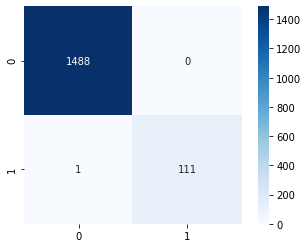

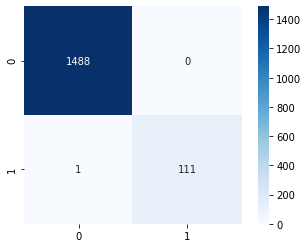

In [11]:
# 推論(学習)
y_pred_ilf = model_ilf.predict(train_ilf.iloc[:,:-2].values)
result_ilf = pd.DataFrame({"y_true": train_ilf["use_label"].values, "y_pred": y_pred_ilf})
y_pred_idf = model_idf.predict(train_idf.iloc[:,:-2].values)
result_idf = pd.DataFrame({"y_true": train_idf["use_label"].values, "y_pred": y_pred_idf})
#スコア(学習)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_ilf = confusion_matrix(result_ilf["y_true"], result_ilf["y_pred"])
cm_idf = confusion_matrix(result_idf["y_true"], result_idf["y_pred"])
plt.figure()
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.figure()
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')

In [12]:
# 特徴量重要度(重要視している単語)
fi_ilf = model_ilf.best_estimator_.feature_importances_
fi_ilf = pd.DataFrame({"word": vocabulary_ilf.keys(), "importance":fi_ilf})
fi_ilf = fi_ilf.sort_values("importance", ascending=False)
display(fi_ilf.head(10))
fi_idf = model_idf.best_estimator_.feature_importances_
fi_idf = pd.DataFrame({"word": vocabulary_idf.keys(), "importance":fi_idf})
fi_idf = fi_idf.sort_values("importance", ascending=False)
display(fi_idf.head(10))

,word,importance
90,NC,94
161,rts,92
6,error,88
12,FATAL,88
14,Error,75
79,on,72
400,storage,62
85,point,62
83,interrupt,60
22,or,58


,word,importance
90,NC,94
161,rts,92
6,error,88
12,FATAL,88
14,Error,75
79,on,72
400,storage,62
85,point,62
83,interrupt,60
22,or,58


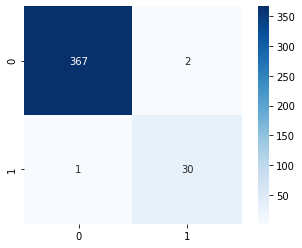

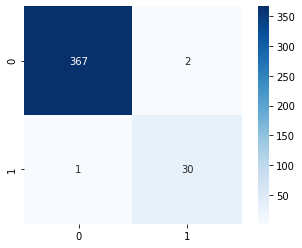

In [13]:
# 推論(推論)
y_pred_ilf = model_ilf.predict(test_ilf.iloc[:,:-2].values)
result_ilf = pd.DataFrame({"y_true": test_ilf["use_label"].values, "y_pred": y_pred_ilf})
y_pred_idf = model_idf.predict(test_idf.iloc[:,:-2].values)
result_idf = pd.DataFrame({"y_true": test_idf["use_label"].values, "y_pred": y_pred_idf})
#スコア(推論)
plt.figure()
cm_ilf = confusion_matrix(result_ilf["y_true"], result_ilf["y_pred"])
sns.heatmap(cm_ilf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.figure()
cm_idf = confusion_matrix(result_idf["y_true"], result_idf["y_pred"])
sns.heatmap(cm_idf, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')

In [14]:
# 異常ログの可視化
test_tmp = test.copy()
test_tmp["pred"] = y_pred_ilf
test_tmp = test_tmp[["log", "pred"]].reset_index()
del test_tmp["index"]
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
test_tmp.style.apply(highlight_greaterthan, threshold=1.0, column=['pred'], axis=1)

,log,pred
0,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.53.58.430277 R22-M1-N0-C:J05-U11 RAS KERNEL INFO generating core.7167,0
1,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.09.13.667082 R62-M0-N2-C:J13-U11 RAS KERNEL INFO iar 001061e8 dear 0247012c,0
2,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.47.33.903841 R62-M1-N3-C:J04-U01 RAS KERNEL INFO iar 003a90fc dear 00b360e8,0
3,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.26.40.236812 R65-M0-N3-C:J04-U01 RAS KERNEL INFO 1524480 double-hummer alignment exceptions,0
4,"2005.08.03 NULL 2005-08-03-16.12.54.271533 NULL RAS MMCS ERROR idoproxydb hit ASSERT condition: ASSERT expression=0 Source file=idotransportmgr.cpp Source line=1043 Function=int IdoTransportMgr::SendPacket(IdoUdpMgr*, BglCtlPavTrace*)",0
5,2005.11.04 R62-M0-NC-C:J04-U01 2005-11-04-09.52.27.280593 R62-M0-NC-C:J04-U01 RAS KERNEL INFO iar 0010686c dear 02f6951c,0
6,2005.07.07 R12-M1-NE-C:J04-U11 2005-07-07-18.41.19.670878 R12-M1-NE-C:J04-U11 RAS KERNEL INFO generating core.815,0
7,2005.06.26 R05-M0-N7-C:J13-U01 2005-06-26-10.28.59.279042 R05-M0-N7-C:J13-U01 RAS KERNEL INFO program interrupt,0
8,2005.07.23 R17-M0-N1-C:J06-U11 2005-07-23-17.45.15.142194 R17-M0-N1-C:J06-U11 RAS KERNEL INFO generating core.14250,0
9,2005.07.10 R26-M1-N9-C:J02-U01 2005-07-10-07.42.50.396450 R26-M1-N9-C:J02-U01 RAS KERNEL INFO generating core.3851,0


# PU Learning①
* **`PU Learningとは`** : 一部の異常データのみラベルを付けて学習/推論を実施する。 

* **`label`** : ラベル付けされている異常ログ=1、ラベル付けされていない正常/異常データ=0とする。

* **`参考`** : https://data-analysis-stats.jp/%e6%a9%9f%e6%a2%b0%e5%ad%a6%e7%bf%92/pulearn%e3%81%a7%e3%81%ae%e9%99%bd%e6%80%a7%e3%81%ae%e3%83%a9%e3%83%99%e3%83%ab%e3%81%a8%e3%83%a9%e3%83%99%e3%83%ab%e3%81%aa%e3%81%97%e3%83%87%e3%83%bc%e3%82%bf%e3%81%ae%e5%88%86%e9%a1%9e%e5%88%86/

In [15]:
!pip install pulearn

In [16]:
train, test = train_test_split(df, train_size=config.train_size, random_state=1, shuffle=True)
train_labeled, train_unlabeled =train_test_split(train[train["label"]==1], train_size=0.5, random_state=1, shuffle=True) 
train_labeled["label"] = -1
train = pd.concat([train[train["label"]==0], train_unlabeled, train_labeled])
#tf-ilf
train_ilf, vocabulary_ilf = FeatureExtraction(train["log(after)"], config, mode="train", fe_type="tfilf")()
test_ilf, _ = FeatureExtraction(test["log(after)"], config, mode="test", fe_type="tfilf")()
train_ilf = pd.DataFrame(train_ilf)
test_ilf = pd.DataFrame(test_ilf)
train_ilf["label_true"] = [1 if (i ==1) or (i==-1)  else 0 for i in train["label"].values] #ラベルなしデータ(0) ラベルあり異常データ(1)
train_ilf["use_label"] = [0 if (i ==1) or (i==0)  else 1 for i in train["label"].values]
test_ilf["label_true"] = test["label"].values #ラベルなしデータ(0) ラベルあり異常データ(1)
test_ilf["use_label"] = test["label"].values
print("===== tf-ilf =====")
display(train_ilf)
display(test_ilf)

tfilf
tfilf
===== tf-ilf =====


,0,1,2,3,4,5,6,7,8,9,...,433,434,435,436,437,438,439,440,label_true,use_label
0,3.578531,3.578531,3.578531,2.887875,2.887875,3.174726,1.636895,2.483241,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
1,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
2,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
3,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
1596,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,1.636895,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
1597,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,4.266716,4.266716,0.0,0.0,0.0,0.0,0.0,1,1
1598,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,1


,0,1,2,3,4,5,6,7,8,9,...,433,434,435,436,437,438,439,440,label_true,use_label
0,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,3.550361,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
396,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
397,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
398,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## SVC

In [17]:
from pulearn import BaggingPuClassifier
from sklearn.svm import SVC
svc = SVC(C=10, kernel="rbf", gamma=0.4, probability=True)
pu_estimator = BaggingPuClassifier(base_estimator=svc, n_estimators=15)
b_pu_clf = pu_estimator.fit(train_ilf.iloc[:,:-2].values, train_ilf["use_label"])
y_pred = b_pu_clf.predict(train_ilf.iloc[:,:-2].values)

C:\Users\81901\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


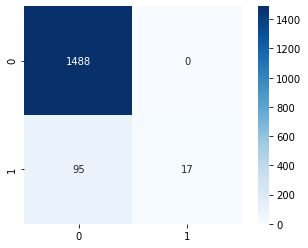

In [18]:
# 推論(学習)
result_pu = pd.DataFrame({"y_true": train_ilf["label_true"].values, "y_pred": y_pred})
#スコア(学習)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_pu = confusion_matrix(result_pu["y_true"], result_pu["y_pred"])
plt.figure()
sns.heatmap(cm_pu, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')

## LightGBM

In [19]:
from pulearn import BaggingPuClassifier
pu_estimator = BaggingPuClassifier(base_estimator=lgb.LGBMClassifier(verbose=-1, max_length=10), n_estimators=15)
b_pu_clf = pu_estimator.fit(train_ilf.iloc[:,:-2].values, train_ilf["use_label"])
y_pred = b_pu_clf.predict(train_ilf.iloc[:,:-2].values)

[LightGBM] [Warning] Unknown parameter: max_length


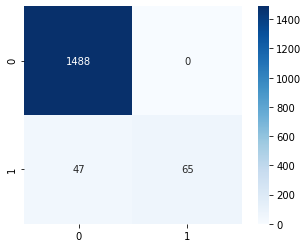

In [20]:
# 推論(学習)
result_pu = pd.DataFrame({"y_true": train_ilf["label_true"].values, "y_pred": y_pred})
#スコア(学習)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_pu = confusion_matrix(result_pu["y_true"], result_pu["y_pred"])
plt.figure()
sns.heatmap(cm_pu, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')

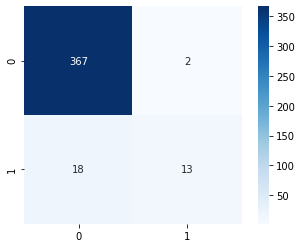

In [21]:
# 推論(推論)
y_pred = b_pu_clf.predict(test_ilf.iloc[:,:-2].values)
result_pu = pd.DataFrame({"y_true": test_ilf["label_true"].values, "y_pred": y_pred})
#スコア(推論)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_pu = confusion_matrix(result_pu["y_true"], result_pu["y_pred"])
plt.figure()
sns.heatmap(cm_pu, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')

In [22]:
# 異常ログの可視化
test_tmp = test.copy()
test_tmp["pred"] = y_pred
test_tmp = test_tmp[["log", "pred"]].reset_index()
del test_tmp["index"]
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
test_tmp.style.apply(highlight_greaterthan, threshold=1.0, column=['pred'], axis=1)

,log,pred
0,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.53.58.430277 R22-M1-N0-C:J05-U11 RAS KERNEL INFO generating core.7167,0
1,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.09.13.667082 R62-M0-N2-C:J13-U11 RAS KERNEL INFO iar 001061e8 dear 0247012c,0
2,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.47.33.903841 R62-M1-N3-C:J04-U01 RAS KERNEL INFO iar 003a90fc dear 00b360e8,0
3,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.26.40.236812 R65-M0-N3-C:J04-U01 RAS KERNEL INFO 1524480 double-hummer alignment exceptions,0
4,"2005.08.03 NULL 2005-08-03-16.12.54.271533 NULL RAS MMCS ERROR idoproxydb hit ASSERT condition: ASSERT expression=0 Source file=idotransportmgr.cpp Source line=1043 Function=int IdoTransportMgr::SendPacket(IdoUdpMgr*, BglCtlPavTrace*)",0
5,2005.11.04 R62-M0-NC-C:J04-U01 2005-11-04-09.52.27.280593 R62-M0-NC-C:J04-U01 RAS KERNEL INFO iar 0010686c dear 02f6951c,0
6,2005.07.07 R12-M1-NE-C:J04-U11 2005-07-07-18.41.19.670878 R12-M1-NE-C:J04-U11 RAS KERNEL INFO generating core.815,0
7,2005.06.26 R05-M0-N7-C:J13-U01 2005-06-26-10.28.59.279042 R05-M0-N7-C:J13-U01 RAS KERNEL INFO program interrupt,0
8,2005.07.23 R17-M0-N1-C:J06-U11 2005-07-23-17.45.15.142194 R17-M0-N1-C:J06-U11 RAS KERNEL INFO generating core.14250,0
9,2005.07.10 R26-M1-N9-C:J02-U01 2005-07-10-07.42.50.396450 R26-M1-N9-C:J02-U01 RAS KERNEL INFO generating core.3851,0


## ========== 参考 =================================================

# PU Learning①
* `参考` : https://github.com/NetManAIOps/LogClass#table-of-contents

## 説明
* **`学習時`**
    * `y_true` : 1(正常と異常が含まれたラベルなしのデータ) or -1(既知の異常データ)
    * `y_pred` : -1(異常) or 1(正常)
* **`推論時`**
    * `y_true` : 1(異常) or 0(正常)
    * `y_pred` : 1(異常) or 0(正常)

In [23]:
train, test = train_test_split(df, train_size=config.train_size, random_state=1, shuffle=True)
train_labeled, train_unlabeled =train_test_split(train[train["label"]==1], train_size=0.5, random_state=1, shuffle=True) 
train_labeled["label"] = -1
train = pd.concat([train[train["label"]==0], train_unlabeled, train_labeled])
#tf-ilf
train_ilf, vocabulary_ilf = FeatureExtraction(train["log(after)"], config, mode="train", fe_type="tfilf")()
test_ilf, _ = FeatureExtraction(test["log(after)"], config, mode="test", fe_type="tfilf")()
train_ilf = pd.DataFrame(train_ilf)
test_ilf = pd.DataFrame(test_ilf)
train_ilf["label"] = train["label"].values
test_ilf["label"] = test["label"].values
# print("===== tf-ilf =====")
# display(train_ilf)
# display(test_ilf)

tfilf
tfilf


In [24]:
#labelの修正
train_ilf["use_label"] = [1 if (i ==0) or (i==1)  else -1 for i in train_ilf["label"].values]
test_ilf["use_label"] = test_ilf["label"].values

In [25]:
# 学習/推論データの準備
x_train = train_ilf.iloc[:,:-2].values
y_train = train_ilf["use_label"].values
x_test = test_ilf.iloc[:,:-2].values
y_test = test_ilf["use_label"].values
# 半教師なし学習
binary_clf = PUAdapterWrapper(config, precomputed_kernel=False)
binary_clf.fit(x_train, y_train)

,y_true,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


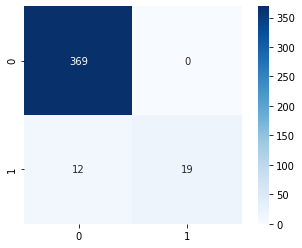

In [26]:
# 推論(推論)
y_pred_pu = binary_clf.predict(x_test)
y_pred_pu = [0 if i==1  else 1 for i in y_pred_pu]
binary_result = pd.DataFrame({"y_true": test_ilf["label"].values, "y_pred": y_pred_pu})
display(binary_result.head())
#スコア(推論)
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure()
cm = confusion_matrix(binary_result["y_true"], binary_result["y_pred"])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')

In [27]:
# 異常ログの可視化
test_tmp = test.copy()
test_tmp["pred"] = y_pred_pu
test_tmp = test_tmp[["log", "pred"]].reset_index()
del test_tmp["index"]
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
test_tmp.style.apply(highlight_greaterthan, threshold=1.0, column=['pred'], axis=1)

,log,pred
0,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.53.58.430277 R22-M1-N0-C:J05-U11 RAS KERNEL INFO generating core.7167,0
1,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.09.13.667082 R62-M0-N2-C:J13-U11 RAS KERNEL INFO iar 001061e8 dear 0247012c,0
2,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.47.33.903841 R62-M1-N3-C:J04-U01 RAS KERNEL INFO iar 003a90fc dear 00b360e8,0
3,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.26.40.236812 R65-M0-N3-C:J04-U01 RAS KERNEL INFO 1524480 double-hummer alignment exceptions,0
4,"2005.08.03 NULL 2005-08-03-16.12.54.271533 NULL RAS MMCS ERROR idoproxydb hit ASSERT condition: ASSERT expression=0 Source file=idotransportmgr.cpp Source line=1043 Function=int IdoTransportMgr::SendPacket(IdoUdpMgr*, BglCtlPavTrace*)",0
5,2005.11.04 R62-M0-NC-C:J04-U01 2005-11-04-09.52.27.280593 R62-M0-NC-C:J04-U01 RAS KERNEL INFO iar 0010686c dear 02f6951c,0
6,2005.07.07 R12-M1-NE-C:J04-U11 2005-07-07-18.41.19.670878 R12-M1-NE-C:J04-U11 RAS KERNEL INFO generating core.815,0
7,2005.06.26 R05-M0-N7-C:J13-U01 2005-06-26-10.28.59.279042 R05-M0-N7-C:J13-U01 RAS KERNEL INFO program interrupt,0
8,2005.07.23 R17-M0-N1-C:J06-U11 2005-07-23-17.45.15.142194 R17-M0-N1-C:J06-U11 RAS KERNEL INFO generating core.14250,0
9,2005.07.10 R26-M1-N9-C:J02-U01 2005-07-10-07.42.50.396450 R26-M1-N9-C:J02-U01 RAS KERNEL INFO generating core.3851,0


# PU Learning②
* `参考` : https://github.com/jojonki/pu-learning

In [28]:
train_ilf["use_label"] = [0 if i >=0  else 1 for i in train_ilf["label"].values]
train_ilf["use_label"] = train_ilf["label"]

In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
class PUClassifier(object):
    def __init__(self, g=None, n_folds=2):
        self.g = g
        self.n_folds = n_folds

    def fit(self, X, s):
        if self.g is None:
            self.g = GridSearchCV(SGDClassifier(loss="log", penalty="l2"), param_grid={"alpha": np.logspace(-4, 0, 10)})

        c = np.zeros(self.n_folds)
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True)
        for i, (train_idx, test_idx) in enumerate(skf.split(X, s)):
            self.g.fit(X[train_idx], s[train_idx])
            c[i] = self.g.predict_proba(X[test_idx][s[test_idx]==1])[:,1].mean()
        self.c = c.mean()
        print('c:', self.c)

    def sample(self, X, s):
        if not hasattr(self, "c"):
            self.fit(X, s)
        X_positive = X[s==1]
        X_unlabeled = X[s==0]
        n_positive = X_positive.shape[0]
        n_unlabeled = X_unlabeled.shape[0]

        X_train = np.r_[X_positive, X_unlabeled, X_unlabeled]
        y_train = np.concatenate([np.repeat(1, n_positive), np.repeat(1, n_unlabeled), np.repeat(0, n_unlabeled)])

        p_unlabeled = self.g.predict_proba(X_unlabeled)[:,1]
        w_positive = ((1 - self.c) / self.c) * (p_unlabeled / (1 - p_unlabeled))
        w_negative = 1 - w_positive
        sample_weight = np.concatenate([np.repeat(1.0, n_positive), w_positive, w_negative])
        return X_train, y_train, sample_weight

In [30]:
# 学習/推論データの準備
x_train = train_ilf.iloc[:,:-2].values
y_train = train_ilf["use_label"].values
x_test = test_ilf.iloc[:,:-2].values
y_test = test_ilf["use_label"].values

pu = PUClassifier(n_folds=5)
print(len(y_train))
X_train, y_train, sample_weight = pu.sample(x_train, y_train)
print(len(y_train))

1600
c: 0.028332143954048983
3032


In [33]:
# # 推論(学習)
# binary_result = pd.DataFrame({"y_true": train_ilf["label"].values, "y_pred": y_train})
# #binary_result["y_true"] = binary_result["y_true"].apply(lambda x: 1 if x==-1 else x)
# #binary_result["y_pred"] = binary_result["y_pred"].apply(lambda x: 1 if x==-1 else 0)
# display(binary_result.head())
# #スコア(学習)
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# cm = confusion_matrix(binary_result["y_true"], binary_result["y_pred"])
# sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')